<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




Comparative Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [ ]:
import cv2
import os
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
import os
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


normal_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Training_Normal_Videos_Anomaly'
anomaly_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting'

saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'

### Utility function for Directory Listing of Video Files

In [ ]:
def list_video_files(directory, extension='*.mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
    # Create a full path pattern by joining directory and extension
    pattern = os.path.join(directory, extension)
    # Use glob to find all files matching the pattern
    video_files = glob.glob(pattern)
    return video_files

### Utility function to shuffle features and labels list Together

In [ ]:
def shuffle_together(list1, list2):
    """
    Shuffle two lists in unison.

    Parameters:
    - list1: The first list to shuffle.
    - list2: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled list1 and list2.
    """
    if len(list1) != len(list2):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    list1_shuffled, list2_shuffled = shuffle(list1, list2)
    return list1_shuffled, list2_shuffled


# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [ ]:
def preprocess_and_segment_video(video_path, resize_shape=(224, 224), segment_length=32):
    """
    Preprocess raw videos by resizing, color space conversion, normalization

    Parameters:
    - video_path: absolute path to video file
    - resize_shape: shape (224,224) to resize video to
    - segment_length: value to segment frames of video to

    Returns:
    - a batch of 32 preprocessed frames of shape (32, 224, 224, 3), using generators
    """
    def video_generator():
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break  # Exit loop if video ends
            frame = cv2.resize(frame, resize_shape)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
            frames.append(frame)

            if len(frames) == segment_length:
                yield np.array(frames)
                frames = []

        # Handle the last segment if it has fewer frames than segment_length
        if frames:  # Check if there are remaining frames
            # Pad the last segment to have 'segment_length' frames
            padding = [np.zeros_like(frames[0]) for _ in range(segment_length - len(frames))]
            frames.extend(padding)
            yield np.array(frames)  # Yield the padded last segment
        cap.release()

    return tf.data.Dataset.from_generator(
        video_generator,
        output_signature=tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32)
    )


### Split Dataset into Training & Validation Sets

In [ ]:
def create_dataset_from_videos(video_paths, labels, resize_shape=(224, 224), segment_length=32):
    """
    Creates a TensorFlow dataset of video segments with corresponding labels.

    Args:
        video_paths (list of str): Paths to video files.
        labels (list of int): Labels for each video file.
        resize_shape (tuple): The target shape for resizing frames.
        segment_length (int): Number of frames per video segment.

    Returns:
        tf.data.Dataset: A dataset of video segments and labels.
    """
    def generator():
        for video_path, label in zip(video_paths, labels):
            # Use preprocess_and_segment_video to yield segments
            for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
                yield segment.numpy(), label

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )


def create_train_val_datasets(anomaly_dir, normal_dir, train_size=0.8, shuffle_buffer_size=100):
    """
    Create training and validation set

    Args:
        anomaly_dir: Path to anomalous videos
        normal_dir: Path to normal videos
        train_size: splitting size for training
        shuffle_buffer_size: shuffle size

    Returns:
        train_dataset, val_dataset
    """
    # list all video files in a directory and their labels
    anomaly_videos, normal_videos = list_video_files(anomaly_dir), list_video_files(normal_dir)
    video_paths = anomaly_videos + normal_videos
    labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)

    # Shuffle video_paths and labels in unison
    video_paths, labels = shuffle_together(video_paths, labels)

    # Create a combined dataset
    dataset = create_dataset_from_videos(video_paths, labels)

    # Calculate dataset sizes
    total_size = len(video_paths)
    train_size = int(total_size * train_size)

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset


# Fine-Tune A Pretrained Video Swin Transformer Model for Video Classification

In [ ]:
def build_finetune_model():
    """
    Fine tune pretrained model

    Returns:
        model (Fine-tuned for shooting classification)
    """
   # import pretrained model, i.e.
    video_swin = keras.models.load_model(saved_model_path, compile= False)
    video_swin.trainable = False

    # downstream model
    model = keras.Sequential([
        video_swin,
        # video_swin outputs a 1D tensor of shape (600,)
        layers.Dense(1024, activation='relu'),  # Additional Dense layer
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
        layers.Dense(1, activation='sigmoid')  # Final Dense layer for binary classification
    ])
    return model


#Train the Fine-Tuned Model for Shooting Classification

In [ ]:
# Split into training and validation data
train_dataset, val_dataset = create_train_val_datasets(anomaly_dir, normal_dir, train_size=0.8, shuffle_buffer_size=100)

# Batch for memory efficiency
batch_size = 1
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Asynchronously fetch batches while model is training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Only use cache() if memory limits won't be exceeded
#train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
#val_dataset = val_dataset.cache().prefetch(tf.data.AUTOTUNE)


finetune_model = build_finetune_model()
# Compile model with binary entropy loss, adam optimizer and metrics
finetune_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Train the model
history = finetune_model.fit(train_dataset, epochs=10,validation_data=val_dataset)


Epoch 1/10
     41/Unknown - 880s 20s/step - loss: 0.0180 - accuracy: 0.9756 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00

KeyboardInterrupt: 

# Evaluate Final Model Performance

NameError: name 'history' is not defined

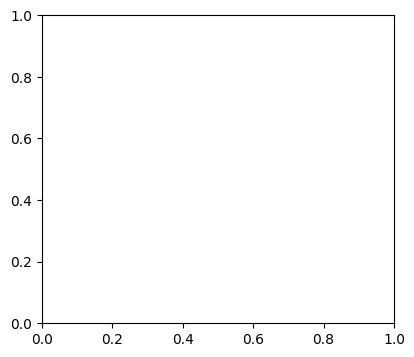

In [ ]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

#References:

*   Sultani, W., Chen, C. and Shah, M., 2018. Real-world anomaly detection in surveillance videos. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Available at: https://www.crcv.ucf.edu/research/real-world-anomaly-detection-in-surveillance-videos/ 20/03/2024.
*   Liu, Z., Hu, H., Lin, Y., Yao, Z., Xie, Z., Wei, Y., Ning, J., Cao, Y., Zhang, Z., Dong, L. and Wei, F., 2022. Swin transformer v2: Scaling up capacity and resolution. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. Available at: https://github.com/innat/VideoSwin 20/03/2024
